In [137]:
import numpy as np 
import torch
from torch.nn import Module
from torch.autograd import grad
import torchvision.datasets as datasets
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import time

In [152]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1000, shuffle=False)
iter_train_loader = iter(train_loader)
iter_test_loader = iter(test_loader)

def get_next_batch(train=True):
    iter_loader = iter_train_loader if train else iter_test_loader
    data_loader = train_loader if train else test_loader
    try:
        # Samples a new batch for persionalizing
        (X, y) = next(iter_loader)
    except StopIteration:
        # restart the generator if the previous generator is exhausted.
        iter_loader = iter(data_loader)
        (X, y) = next(iter_loader)
    return (X, y)

In [153]:
# SGD optimizer
model = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
loss_fn = nn.CrossEntropyLoss(reduce="Mean")
sgd = torch.optim.SGD(model.parameters(), lr=0.1)
losses = []
start = time.time()
for epoch in range(1, 401):
    X_train, y_train = get_next_batch(train=True)
    model.zero_grad()
    loss = loss_fn(model(X_train), y_train)
    loss.backward()
    sgd.step()
    losses.append(loss.data.clone().detach())
compute_time = time.time() - start

In [182]:
def richardson_iter(grads, model, alpha=0.1, num_iters=20):
    newton_direction = [torch.zeros_like(param.data) for param in model.parameters()]
    for it in range(1, num_iters + 1):
        model.zero_grad()
        Hv = torch.autograd.grad(grads, 
                                 model.parameters(), 
                                 grad_outputs=newton_direction, 
                                 create_graph=False, 
                                 retain_graph=True)
        for dt, hv, grad in zip(newton_direction, Hv, grads):
            dt.data = dt.data - alpha * hv - alpha * grad.data
    return newton_direction

In [183]:
# Newton Method with Richardson Iteration
model2 = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
loss_fn2 = nn.CrossEntropyLoss(reduce="Mean")
losses2 = []
start = time.time()
for epoch in range(1, 401):
    model2.zero_grad()
    X_train, y_train = get_next_batch(train=True)
    loss = loss_fn2(model2(X_train), y_train)
    grads = torch.autograd.grad(loss, model2.parameters(), create_graph=True)
    directions = richardson_iter(grads, model2)
    for param, direction in zip(model2.parameters(), directions):
        param.data += direction.data
    losses2.append(loss)
compute_time2 = time.time() - start

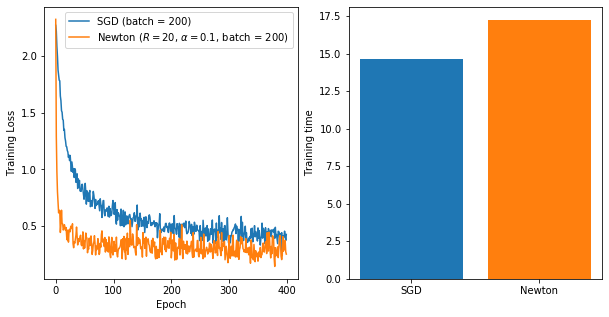

In [185]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(losses, label="SGD (batch = 200)")
plt.plot(losses2, label="Newton ($R = 20$, $\\alpha = 0.1$, batch = 200)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.subplot(122)
plt.bar(["SGD"], compute_time)
plt.bar(["Newton"], compute_time2)
plt.ylabel("Training time")
plt.savefig("newton_method.pdf", bbox_inches="tight")

In [149]:
compute_time

8.61610198020935

In [150]:
compute_time2

11.58643889427185